# Predicting Wine Quality From Chemical Composition
***

The goal of this project is to attempt to predict quality of wine based on its chemical properties.

The project uses the [Wine Quality](https://archive.ics.uci.edu/ml/datasets/Wine+Quality) dataset, publicly available from the [UCI ML data repository](https://archive.ics.uci.edu/ml/datasets.php).

The dataset contains chemical properties and associated quality scores for red and white variants of Portuguese "Vinho Verde" wine. 

The scores range from 1 to 9, and come from human tasters as part of the wine certification process to ensure quality and safety of the wine, and can also be used to refine wine making process and to stratify wines into premium brands.

The dataset is accompanied by a paper, ["Modeling wine preferences by data mining from physicochemical properties"](http://dx.doi.org/10.1016/j.dss.2009.05.016) by P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis, which approaches the task as a regression problem to predict the scores, but I will instead approach it as a classification problem, and instead attempt to predict if a given wine is "great" or just "regular".

To accomplish this, I will transform the quality score into a binary (0/1) class, signifying a "regular" or "great" wine based on the score ranges, and then train various classification algorithms to predict whether a wine will be "great".

Specific classification algorithms evaluated:
* K-Nearest Neighbors
* Random Forest Classifier
* Support Vector Classifier
* Multi-layer Perceptron


## Data Cleanup

The dataset contains two separate CSV files, one for white and one for red variants. 

I will focus only on the white variant, since it has significantly more observations, 4898 for white versus 1599 for red.

In [1]:
# import the dataset
import pandas as pd

df = pd.read_csv('/home/max/code/msds-supervised-learning-final/data/winequality-white.csv', sep=';')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [2]:
# remove spaces from column names
df = df.rename(columns={
    'fixed acidity': 'fixed_acidity', 'volatile acidity':'volatile_acidity',
    'citric acid': 'citric_acid', 'residual sugar': 'residual_sugar',
    'free sulfur dioxide': 'free_sulfur_dioxide', 'total sulfur dioxide': 'total_sulfur_dioxide'
})

### Data Cleanup Conclusion

The data has 4898 observations and 12 features, and does not have any missing values.

**quality** is the dependent variable, and other 11 variables are the independent variables, used to predict **quality**.

All of the independent variables are continuous and of type "float" (decimal fractions), and **quality** is an integer.

Column names contain spaces, which can cause issues with various libraries, so I replaced spaces with underscore character.

## Exploratory Data Analysis

**quality** is the dependent variable, so lets explore its distribution.

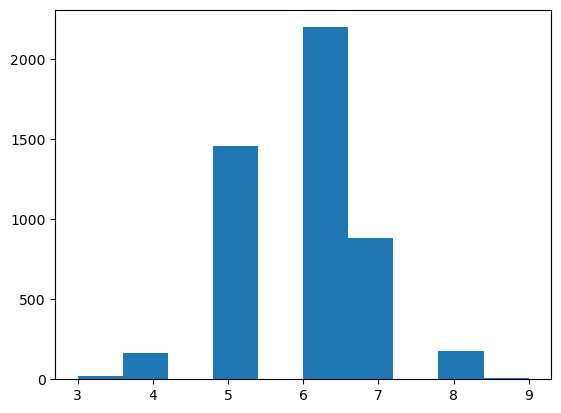

Quality score values and their counts:
6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64


In [3]:
import matplotlib.pyplot as plt

df['quality'].hist(grid=False)
plt.show()
print("Quality score values and their counts:")
print(df['quality'].value_counts())

Most of the wines fall into mid-range of the score, with relatively few being "poor" or "great", creating a significant class imbalance.

Additionally, the dataset description states that **quality** ranges from 1 to 9, but turns out its actually from 3 to 9.

### Correlation Matrix

Next, lets see if there are any obvious correlations in the data, specifically between **quality** and any of the other features.

<AxesSubplot:>

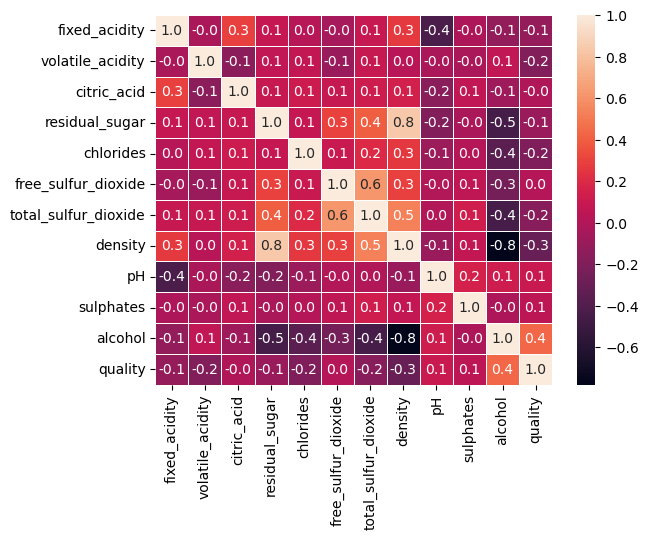

In [4]:
# exploring the corelation matrix
import seaborn as sns

corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".1f", linewidth=.5)

In [5]:
corr_pairs = corr.unstack()
sorted_corr_pairs = corr_pairs.sort_values(ascending=False)
print('Correlation values between quality and other columns')
print(sorted_corr_pairs['quality'])

Correlation values between quality and other columns
quality                 1.000000
alcohol                 0.435575
pH                      0.099427
sulphates               0.053678
free_sulfur_dioxide     0.008158
citric_acid            -0.009209
residual_sugar         -0.097577
fixed_acidity          -0.113663
total_sulfur_dioxide   -0.174737
volatile_acidity       -0.194723
chlorides              -0.209934
density                -0.307123
dtype: float64



According to the matrix, there are some strong correlations between other features (rounded to nearest decimal):

* Positive 0.8 between **residual_sugar** and **density**, meaning overall density will tend to be higher with more residual sugar and vice versa, which makes sense, since density of sugar is 1.59 g/cm³ (https://en.wikipedia.org/wiki/Sucrose) which is greater than water, which is the dominant component of wine (about 85% according to https://www.wsetglobal.com/knowledge-centre/blog/2021/december/14/what-is-wine/)

* Negative -0.8 between **density** and **alcohol**, meaning overall density will tend to be lower with higher alcohol content and vice versa, which also makes sense, since density of alcohol is 0.789 g/cm³ (https://en.wikipedia.org/wiki/Ethanol) which is less than water.

* Positive 0.6 between **total_sulfur_dioxide** and **free_sulfur_dioxide**


### Using Linear Regression to check for any statistically significant features

Next, I will use Linear Regression to see if any of the features can be used to predict the **quality** score.

Specifically, I will use Forward Stepwise Refinement with k=5 to attempt to find best regression model.

In [6]:
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import statsmodels.api as sm

# create training and testing datasets
X_train, X_test = train_test_split(df, train_size=0.8, test_size=0.2)

allowed_factors = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
    'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol']

for k in range(0, 5):    
    best = ['',0]
    for p in allowed_factors:
        
        # base case, do not have a trained model yet
        if k == 0:
            model = smf.ols(formula='quality ~ '+ p, data=X_train).fit()
            
        # use best model from previous iteration
        else:
            model = smf.ols(formula=train.model.formula + ' + ' + p, data=X_train).fit()
            
        if model.rsquared>best[1]:
            best = [p, model.rsquared]

    # base case, current best model
    if k == 0:
        train = smf.ols(formula='quality ~ ' + best[0], data=X_train).fit()
        
    # use previous best model combined with best model learned at this iteration
    else:
        train = smf.ols(formula=train.model.formula + ' + ' + best[0], data=X_train).fit()

print('r-squared:', train.rsquared)
print("\n")
print("p-values:")
print(train.pvalues)
print("\n")
print("t-values:")
print(train.tvalues)

r-squared: 0.2711230495222544


p-values:
Intercept            2.644658e-48
alcohol             3.270207e-218
volatile_acidity     8.120845e-68
residual_sugar       3.276922e-23
fixed_acidity        5.570476e-07
sulphates            3.152692e-06
dtype: float64


t-values:
Intercept           14.806395
alcohol             33.646910
volatile_acidity   -17.744280
residual_sugar       9.987333
fixed_acidity       -5.013890
sulphates            4.667389
dtype: float64


The linear regression model has a very low R-squared number, even though it uses multiple features, all with low p-values, which confirms my conclusion from the correlation matrix that there are no statistically significant features which can predict the **quality** score.

### Exploratory Data Analysis Conclusion

Majority of wines fall into the middle range of the **quality** score, creating a significant class imbalance for a "great" versus "regular" classification task.

Additionally, according to the correlation matrix and an attempt to fit a linear regression model to predict the **quality** score, there are no statiscally significant features affecting the score value.

## Classification - Feature Engineering

### Adding "is_great" column

To perform classification, I will add a new column **is_great**, which will have a value of 1 or 0, and will be based on the ranges of **quality** values.

In [7]:
# adding 'is_great' column, and dropping 'quality'
import numpy as np

df['is_great'] = np.where(df['quality'] >= 7, 1, 0)
df = df.drop(['quality'], axis=1)

### Dealing with class imbalance

Since most wine scores are less than 7, there is a significant class imbalance in the data.

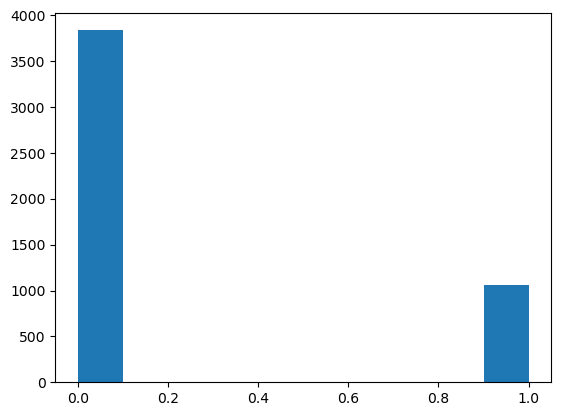

is_great values and their counts:
0    3838
1    1060
Name: is_great, dtype: int64


In [8]:
# is_great class imbalance
df['is_great'].hist(grid=False)
plt.show()

print("is_great values and their counts:")
print(df['is_great'].value_counts())

There are two possible approaches to deal with the imbalance. 

Since **is_great=1** has 1060 samples, I can pull out a random set of 1060 samples where **is_great=0**, and use that as my training and test data, but this approach significantly reduces data available for training.

Another approach is oversampling the minority class, where new data is generated to increase the amount of **is_great=1** observations. Specifically, I will use the [Synthetic Minority Oversampling Technique (SMOTE), by Nitesh Chawla, et al.](https://arxiv.org/abs/1106.1813).

In [9]:
# SMOTE oversampling
from imblearn.over_sampling import SMOTE 

oversample = SMOTE()

df, y =  oversample.fit_resample(df.drop(["is_great"],axis=1), df["is_great"])
df['is_great'] = y

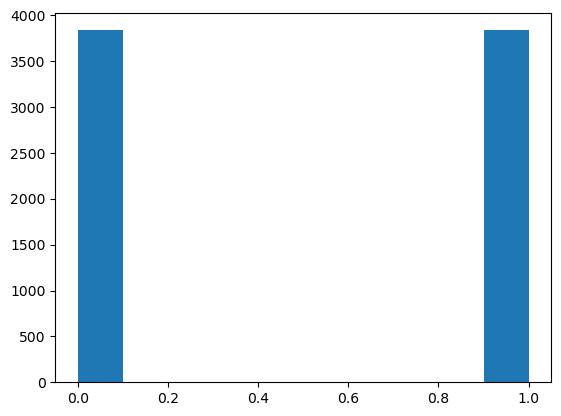

is_great values and their counts:
0    3838
1    3838
Name: is_great, dtype: int64


In [10]:
# new counts for is_great=1
df['is_great'].hist(grid=False)
plt.show()

print("is_great values and their counts:")
print(df['is_great'].value_counts())

After oversampling, counts of **is_great=1** and **is_great=0** are the same.

### Feature Scaling

Next issue with the data are significant differences in ranges of values of the features.

For example mean of **volatile_acidity** is about 0.27, but mean of **total_sulfur_dioxide** is about 133. 

This difference would not significantly affect tree-based algorithms such as Random Forest, since each split of a node is done on a specific feature and other features do not affect the split, but this difference would be significant for K-Nearest Neighbors or Support Vector Classifier since they use a distance metric, and scaling the features will ensure that all features contribute equally to the training.

In [11]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,is_great
count,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000
mean,6.808739,0.273375,0.331458,5.912318,0.043078,34.954989,133.370315,0.993410,3.196600,0.493736,10.844042,0.500000
std,0.783870,0.094680,0.104521,4.792992,0.018839,15.895869,39.825334,0.002985,0.145453,0.114633,1.275399,0.500033
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.300000,0.209447,0.280000,1.800000,0.034000,24.000000,104.708439,0.991100,3.100000,0.410000,9.700000,0.000000
50%,6.800000,0.260000,0.317176,4.500000,0.040000,33.342126,128.698755,0.992800,3.190000,0.480000,10.900000,0.500000
75%,7.300000,0.320000,0.370000,8.891587,0.048000,44.000000,158.000000,0.995460,3.290000,0.552630,11.900000,1.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,1.000000


I will use the Normalization (MinMax Scaling) approach to scaling, which will make all feature values fall in the range from 0 to 1.

In [12]:
from sklearn import preprocessing

X, y =  df.drop(["is_great"],axis=1), df["is_great"]

scaler = preprocessing.MinMaxScaler()
names = X.columns
d = scaler.fit_transform(X)

df = pd.DataFrame(d, columns=names)
df['is_great'] = y

In [13]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,is_great
count,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000,7676.000000
mean,0.289302,0.189583,0.199673,0.081477,0.101123,0.114826,0.288562,0.121454,0.433273,0.318298,0.458716,0.500000
std,0.075372,0.092823,0.062964,0.073512,0.055902,0.055386,0.092402,0.057557,0.132230,0.133295,0.205710,0.500033
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.240385,0.126909,0.168675,0.018405,0.074184,0.076655,0.222061,0.076923,0.345455,0.220930,0.274194,0.000000
50%,0.288462,0.176471,0.191070,0.059816,0.091988,0.109206,0.277723,0.109697,0.427273,0.302326,0.467742,0.500000
75%,0.336538,0.235294,0.222892,0.127172,0.115727,0.146341,0.345708,0.160979,0.518182,0.386779,0.629032,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


All feature values are now in range from 0 to 1.

## Classification - Model Selection and Analysis

Load various metrics and some helper functions

In [14]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix 
from sklearn.metrics import classification_report, matthews_corrcoef, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import time

# ignore sklearn warnings
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

# confusion matrix plot
def plot_conf_mat(conf_matrix):
    plt.rcParams["figure.autolayout"] = False
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title('Confusion Matrix', fontsize=12)
    plt.show()

# ROC area under curve plot
def plot_roc(roc_auc):       
    plt.rcParams["figure.autolayout"] = False
    plt.figure(figsize=(3, 3))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Great Wine ROC')
    plt.legend(loc="lower right")
    plt.show()

### K-Nearest Neighbors

First model to try is K-Nearest Neighbors (KNN). KNN has several hyperparameters, so I will use GridSearch to find most optimal hyperparameter set.

Following hyperparameters are available:
* **n_neighbors** - number of neighbor points to consider for classification, default = 5
* **weights** - weight for points, *uniform* - all points have same weight, *distance* - closer neighbors will have greater influence, default = 'uniform'
* **metric** - distance metric to use, *minkowski*, *euclidean*, *manhattan*, default = 'minkowski'

In [49]:
from sklearn.neighbors import KNeighborsClassifier

# train and test set
train_X, test_X, train_y, test_y = train_test_split(df.drop(["is_great"],axis=1), df["is_great"], train_size=0.8)

params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'euclidean', 'manhattan']
}

start_time = time.time()

grid = GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1)

res = grid.fit(train_X, train_y)

print("Total training time (seconds):", time.time() - start_time)

print("Best parameters:", grid.best_params_)
print("Score:", grid.best_score_)

Total training time (seconds): 4.158559322357178
Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Score: 0.8721498371335505


Now lets test the best KNN classifier.

              precision    recall  f1-score   support

           0       0.96      0.82      0.88       777
           1       0.84      0.97      0.90       759

    accuracy                           0.89      1536
   macro avg       0.90      0.89      0.89      1536
weighted avg       0.90      0.89      0.89      1536



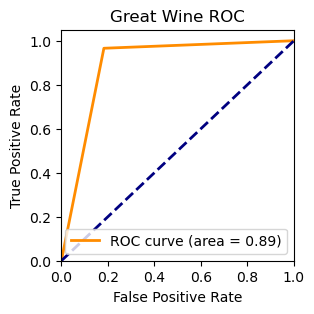

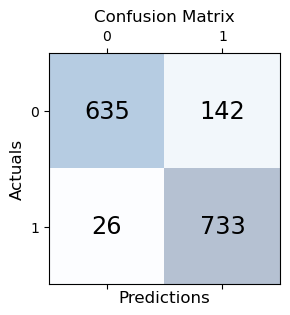

In [50]:
yhat = grid.predict(test_X)

# metrics
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
plot_roc(roc_auc)

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
plot_conf_mat(conf_matrix)

KNN performed well, ROC area under curve is 0.89.

### Random Forest 

Next, I will evaluate Random Forest classifier.

I will use following hyperparameters for GridSearch optimization:

* **n_estimators** - number of decision trees in the forest
* **max_depth** - maximum depth of the tree
* **ccp_alpha** - complexity parameter which controls pruning of terminal nodes based on total misclassification rate

In [51]:
from sklearn.ensemble import RandomForestClassifier

# train and test set
train_X, test_X, train_y, test_y = train_test_split(df.drop(["is_great"],axis=1), df["is_great"], train_size=0.8)

params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [2, 4, 8, 16, 32],
    'ccp_alpha': [0, 0.1, 0.5, 0.8]
}

start_time = time.time()

grid = GridSearchCV(RandomForestClassifier(), params, n_jobs=-1)

res = grid.fit(train_X, train_y)

print("Total training time (seconds):", time.time() - start_time)

print("Best parameters:", grid.best_params_)
print("Score:", grid.best_score_)

Total training time (seconds): 36.817532539367676
Best parameters: {'ccp_alpha': 0, 'max_depth': 32, 'n_estimators': 100}
Score: 0.9014657980456026


Testing the best found classifier

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       745
           1       0.89      0.93      0.91       791

    accuracy                           0.90      1536
   macro avg       0.90      0.90      0.90      1536
weighted avg       0.90      0.90      0.90      1536



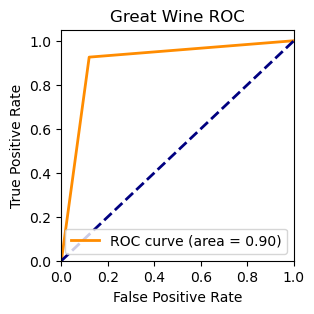

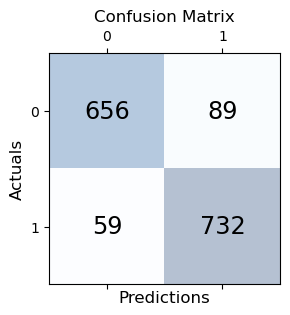

In [52]:
yhat = grid.predict(test_X)

# metrics
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
plot_roc(roc_auc)

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
plot_conf_mat(conf_matrix)

Random Forest performed slightly better than KNN, with ROC area under the curve of 0.90.

### Support Vector Classifier

Next, lets examine Support Vector Classifier.

Following hyperparameters to be used with GridSearch:

* **gamma** - controls the complexity of the decision plane, larger values increase complexity
* **C** - missclassification tolerance, controls the size of the margin, smaller values increase margin and allow for more errors
* **kernel** - kernel to use

In [53]:
from sklearn.svm import SVC

# train and test set
train_X, test_X, train_y, test_y = train_test_split(df.drop(["is_great"],axis=1), df["is_great"], train_size=0.8)

params = {
    'gamma': [0.1, 1, 2, 5, 10],
    'C': [0.1, 1, 2, 5, 10],
    'kernel': ['poly', 'rbf', 'sigmoid']
}

start_time = time.time()

grid = GridSearchCV(SVC(), params, n_jobs=-1)

res = grid.fit(train_X, train_y)

print("Total training time (seconds):", time.time() - start_time)

print("Best parameters:", grid.best_params_)
print("Score:", grid.best_score_)

Total training time (seconds): 194.57688355445862
Best parameters: {'C': 10, 'gamma': 10, 'kernel': 'rbf'}
Score: 0.8333876221498372


Testing the best found classifier

              precision    recall  f1-score   support

           0       0.90      0.81      0.85       774
           1       0.82      0.91      0.87       762

    accuracy                           0.86      1536
   macro avg       0.86      0.86      0.86      1536
weighted avg       0.86      0.86      0.86      1536



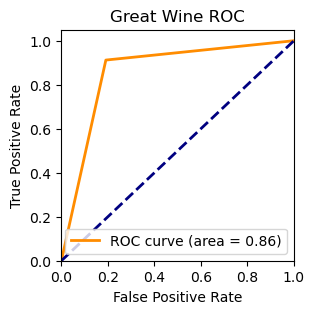

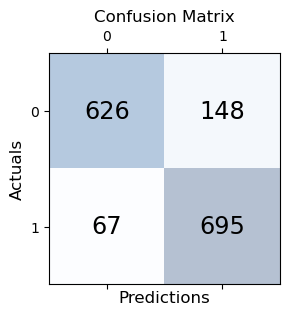

In [54]:
yhat = grid.predict(test_X)

# metrics
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
plot_roc(roc_auc)

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
plot_conf_mat(conf_matrix)

SVC performed worse than either KNN or Random Forest, with total area under ROC curve of 0.86.

Additionally, the training time via GridSearch was significantly higher than either KNN or Random Forest.

### Multi-layer Perceptron

Multi-layer Perceptron is a neural network, and generally performs well for binary classification.

Following hyperparameters to be used with GridSearch:

* **hidden_layer_sizes** - neural network hidden layers architecture
* **activation** - activation function
* **alpha** - constant to multiply the L2 regularization term
* **learning_rate** - gradient descent step

In [16]:
from sklearn.neural_network import MLPClassifier

# train and test set
train_X, test_X, train_y, test_y = train_test_split(df.drop(["is_great"],axis=1), df["is_great"], train_size=0.8)

params = {
    'hidden_layer_sizes': [(100,), (10,10,), (10,20,10)],
    'activation': ['logistic', 'tanh', 'relu'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant','adaptive', 'invscaling']
}

start_time = time.time()

grid = GridSearchCV(MLPClassifier(), params, n_jobs=-1, verbose=2)

res = grid.fit(train_X, train_y)

print("Total training time (seconds):", time.time() - start_time)

print("Best parameters:", grid.best_params_)
print("Score:", grid.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  5.5min finished


Total training time (seconds): 335.8865866661072
Best parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling'}
Score: 0.7905537459283388


Testing the best found classifier

In [18]:
yhat = grid.predict(test_X)

              precision    recall  f1-score   support

           0       0.79      0.76      0.77       762
           1       0.77      0.80      0.79       774

    accuracy                           0.78      1536
   macro avg       0.78      0.78      0.78      1536
weighted avg       0.78      0.78      0.78      1536



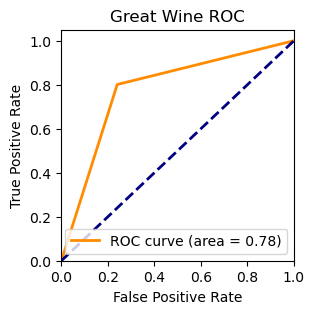

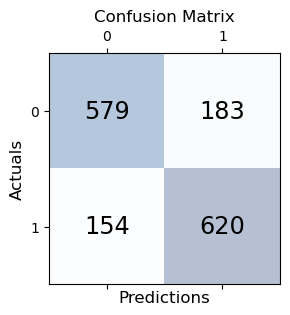

In [20]:
# metrics
print(classification_report(test_y, yhat))

# roc
fpr, tpr, thresholds = roc_curve(test_y, yhat)
roc_auc = auc(fpr, tpr)
plot_roc(roc_auc)

# confusion matrix
conf_matrix = confusion_matrix(test_y, yhat)
plot_conf_mat(conf_matrix)

Multi-layer Perceptron performed the worst out of all classifiers tested, with area under the ROC curve at about 0.78.

Additionally, there were a lot of convergence errors, and training via GridSearch took the longest out of all classifiers considered.

## Classification - Conclusions

### Model Performance - Predicting a great wine - RandomForest Wins

I chose area under ROC curve as the preformance metric because it clearly shows the amount of true positives, which is the best way to measure binary classification for the "positive" class, i.e. a "great" wine.

I found that K-Nearest Neighbors and Random Forest classifiers performed the best out of the ones tested.

Multi-layer Perceptron has the worst performance, followed by Support Verctor classifier.

Here is a simple bar plot comparing area under ROC curve metrics for the tested classifiers. 

The metrics come from the output of the classifier validation cells.

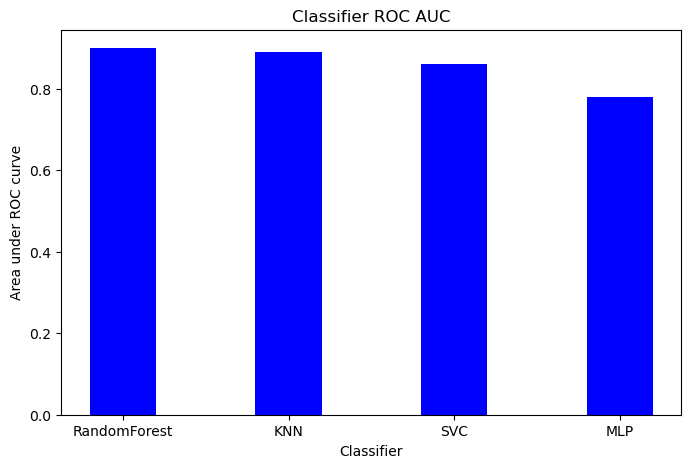

In [28]:
perf_data = {'RandomForest':0.90, 'KNN':0.89, 'SVC':0.86, 'MLP':0.78}

fig = plt.figure(figsize = (8, 5))

plt.bar(perf_data.keys(), perf_data.values(), color ='blue', width = 0.4)

plt.xlabel("Classifier")
plt.ylabel("Area under ROC curve")

plt.title("Classifier ROC AUC")

plt.show()


Considering that all trained classifiers had predictive performance as measured by ROC curve area equal to or greater than 78%, we can conclude that it is definitely possible to use a statistical algorithm to predict if a wine is "great" based on the chemical features from the dataset. 

### Model Performance - Model Training Times - KNN Wins

In addition to classifier's predictive performance, I also collected data on training times with GridSearch for each of the classifiers.

This data shows that even though KNN has slightly lower predictive performance, its training time is significantly less than that of any other classifier, including the best performing RandomForest.

The metrics come from the output of the classifier training cells.

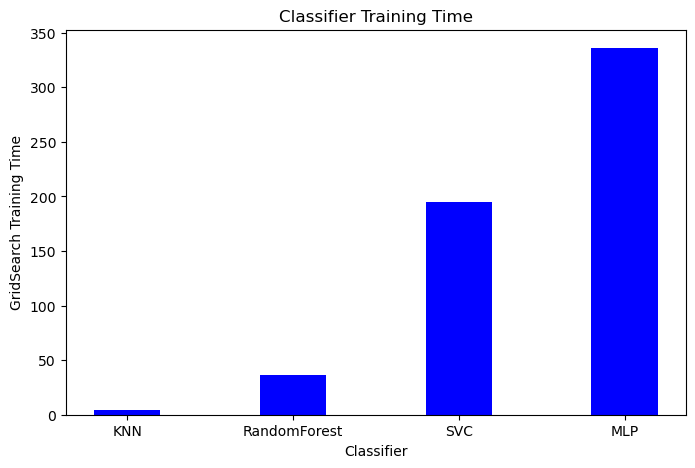

In [30]:
perf_data = {'KNN':4.15, 'RandomForest':36.81, 'SVC':194.57, 'MLP':335.88}

fig = plt.figure(figsize = (8, 5))

plt.bar(perf_data.keys(), perf_data.values(), color ='blue', width = 0.4)

plt.xlabel("Classifier")
plt.ylabel("GridSearch Training Time")

plt.title("Classifier Training Time")

plt.show()


### Interpreting the Results, Future Work

Regular correlation matrix of the features, and attempting to fit a simple linear regression model to predict the raw quality score did not find any obvious significant predictors.

However, since the best performing classifier turned out to be a RandomForest model, it is possible to see what features were the most influential for that model. 

Each feature has a Gini importance value, with more important features having higher values, and all of the values add to 1, so they can be interpreted as a percentage.

In [34]:
from sklearn.ensemble import RandomForestClassifier

# train and test set
train_X, test_X, train_y, test_y = train_test_split(df.drop(["is_great"],axis=1), df["is_great"], train_size=0.8)

# best parameters found via GridSearch:
# {'ccp_alpha': 0, 'max_depth': 32, 'n_estimators': 100}
clf = RandomForestClassifier(ccp_alpha=0, max_depth=32, n_estimators=100)
res = clf.fit(train_X, train_y)

pd.DataFrame({'Variable':train_X.columns,
    'Importance':clf.feature_importances_}).sort_values('Importance', ascending=False)


,Variable,Importance
10,alcohol,0.185701
7,density,0.119240
4,chlorides,0.098542
1,volatile_acidity,0.089582
3,residual_sugar,0.084812
2,citric_acid,0.078195
6,total_sulfur_dioxide,0.075400
5,free_sulfur_dioxide,0.074154
0,fixed_acidity,0.069619
8,pH,0.067242


It appears that alcohol content, followed by density, are the two most influential features for node splitting in a RandomForest model.

This somewhat coincides with the values from the correlation matrix of the raw scores in **quality** column and other features.

Even though the correlation values were still less than 0.5, they were highest for alcohol content and density.

Correlation matrix values for **quality**:  
quality                 1.000000  
**alcohol                 0.435575**  
pH                      0.099427  
sulphates               0.053678  
free_sulfur_dioxide     0.008158  
citric_acid            -0.009209  
residual_sugar         -0.097577  
fixed_acidity          -0.113663  
total_sulfur_dioxide   -0.174737  
volatile_acidity       -0.194723  
chlorides              -0.209934  
**density                -0.307123**  

The correlation matrix also showed a strong negative correlation (-0.8) between alcohol and density, as well as a strong positive correlation (0.8) between residual sugar and density.

The quality score comes from human tasters, and it is possible that alcohol content and residual sugar content - both having a strong correlation to density - are the most noticeable sensory inputs from the list provided in the dataset, and therefore contribute to the final score more than any of the other features.

A future study could use the same chemical properties from this dataset, but also include some sort of "flavor" feature. This "flavor" feature could be something subjective, such as "sweet" or "sour" or "dry", as percieved by the human tasters, and then correlations between this "flavor" and the raw quality scores can be examined.

It may also be possible to find correlations between specific combinations of the chemical features presented in this dataset and the subjective "flavor".

Finally, a future study to predict a "great" wine can use a subjective "flavor" feature along with the quality score and chemical properties listed in this dataset, and chemical properties found in another wine dataset: [https://archive.ics.uci.edu/ml/datasets/Wine](https://archive.ics.uci.edu/ml/datasets/Wine), specifically:
* Malic acid
* Ash
* Alcalinity of ash
* Magnesium
* Total phenols
* Flavanoids
* Nonflavanoid phenols
* Proanthocyanins
* Color intensity
* Hue
* OD280/OD315 of diluted wines
* Proline 


